In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

### download dataset from kaggle

You can get the kaggle.json after singing in to kaggle by navigating to settings menu.

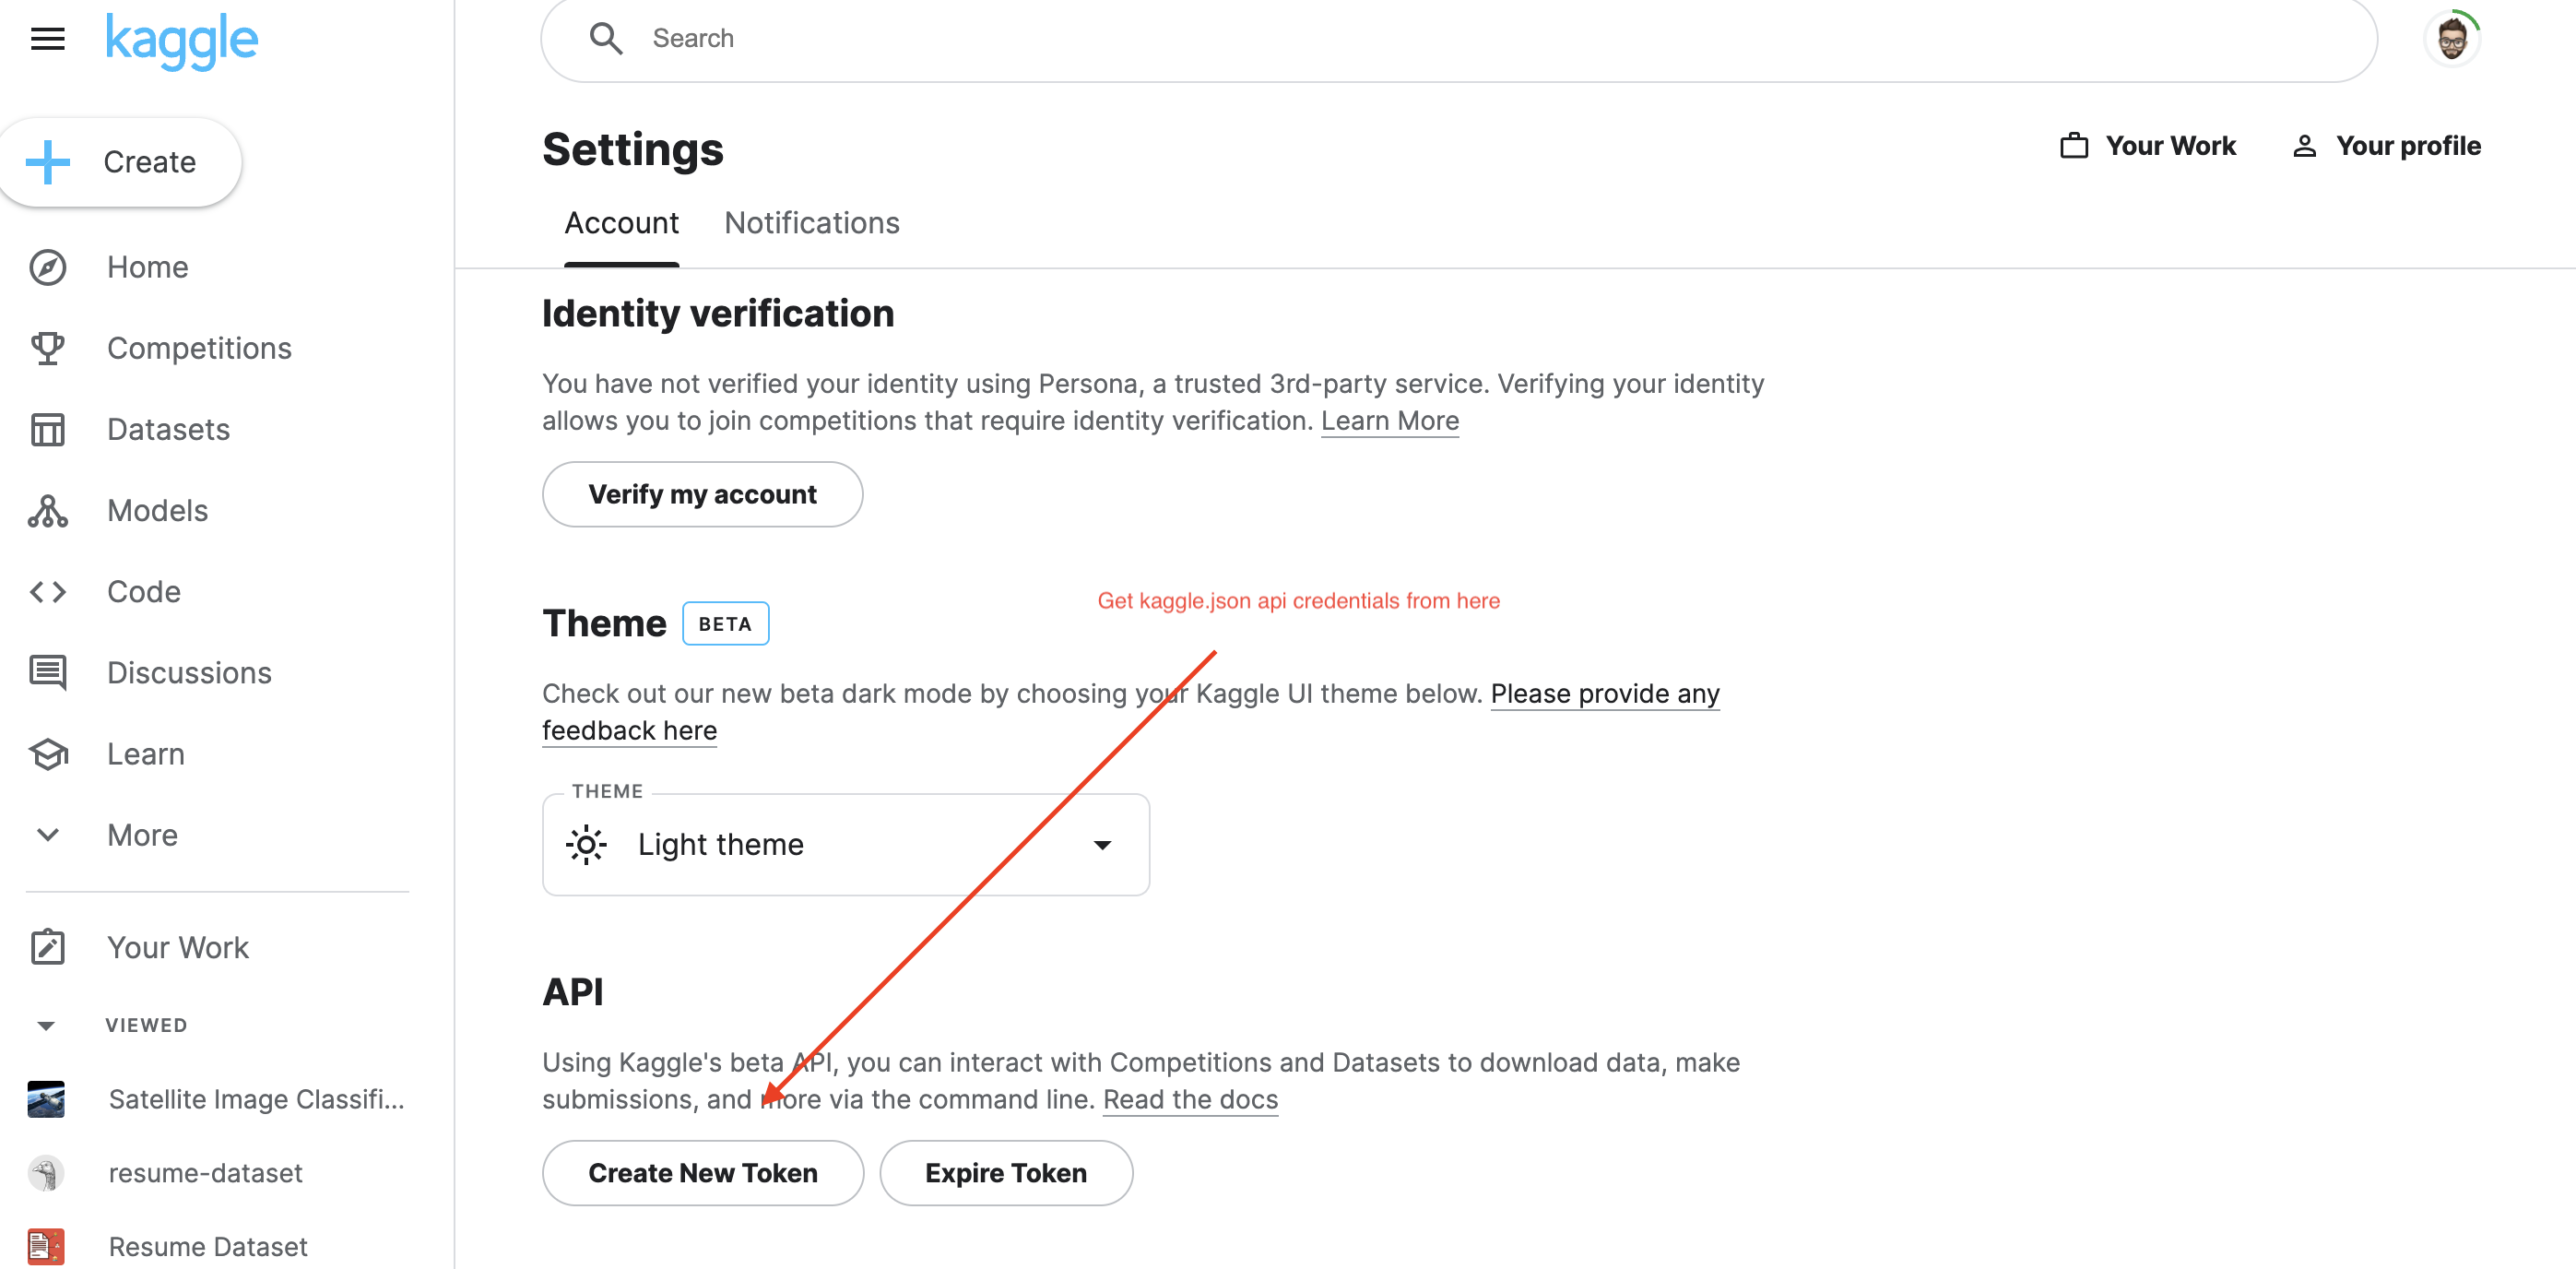

In [2]:
# put kaggle.json inside content
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [3]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
 23% 5.00M/21.8M [00:00<00:00, 50.6MB/s]
100% 21.8M/21.8M [00:00<00:00, 133MB/s] 


In [ ]:
!unzip satellite-image-classification.zip

after extracting data from zip file, you will see `file` folder which will have all the images

In [6]:
!ls .

data  kaggle.json  sample_data	satellite-image-classification.zip


### create data csv file

In [7]:
image_path_list = []
label_list = []

for class_cat in os.listdir("data"):
  for image_object in os.listdir(f"data/{class_cat}"):
    image_path_list.append(f"data/{class_cat}/{image_object}")
    label_list.append(f"{class_cat}")

df = pd.DataFrame()

df["image_path"] = image_path_list
df["label"] = label_list

df

,image_path,label
0,data/water/SeaLake_2929.jpg,water
1,data/water/SeaLake_2892.jpg,water
2,data/water/SeaLake_2.jpg,water
3,data/water/SeaLake_1492.jpg,water
4,data/water/SeaLake_1249.jpg,water
...,...,...
5626,data/green_area/Forest_838.jpg,green_area
5627,data/green_area/Forest_2008.jpg,green_area
5628,data/green_area/Forest_2302.jpg,green_area
5629,data/green_area/Forest_2191.jpg,green_area


plotting some of images from to get some idea about different types of image

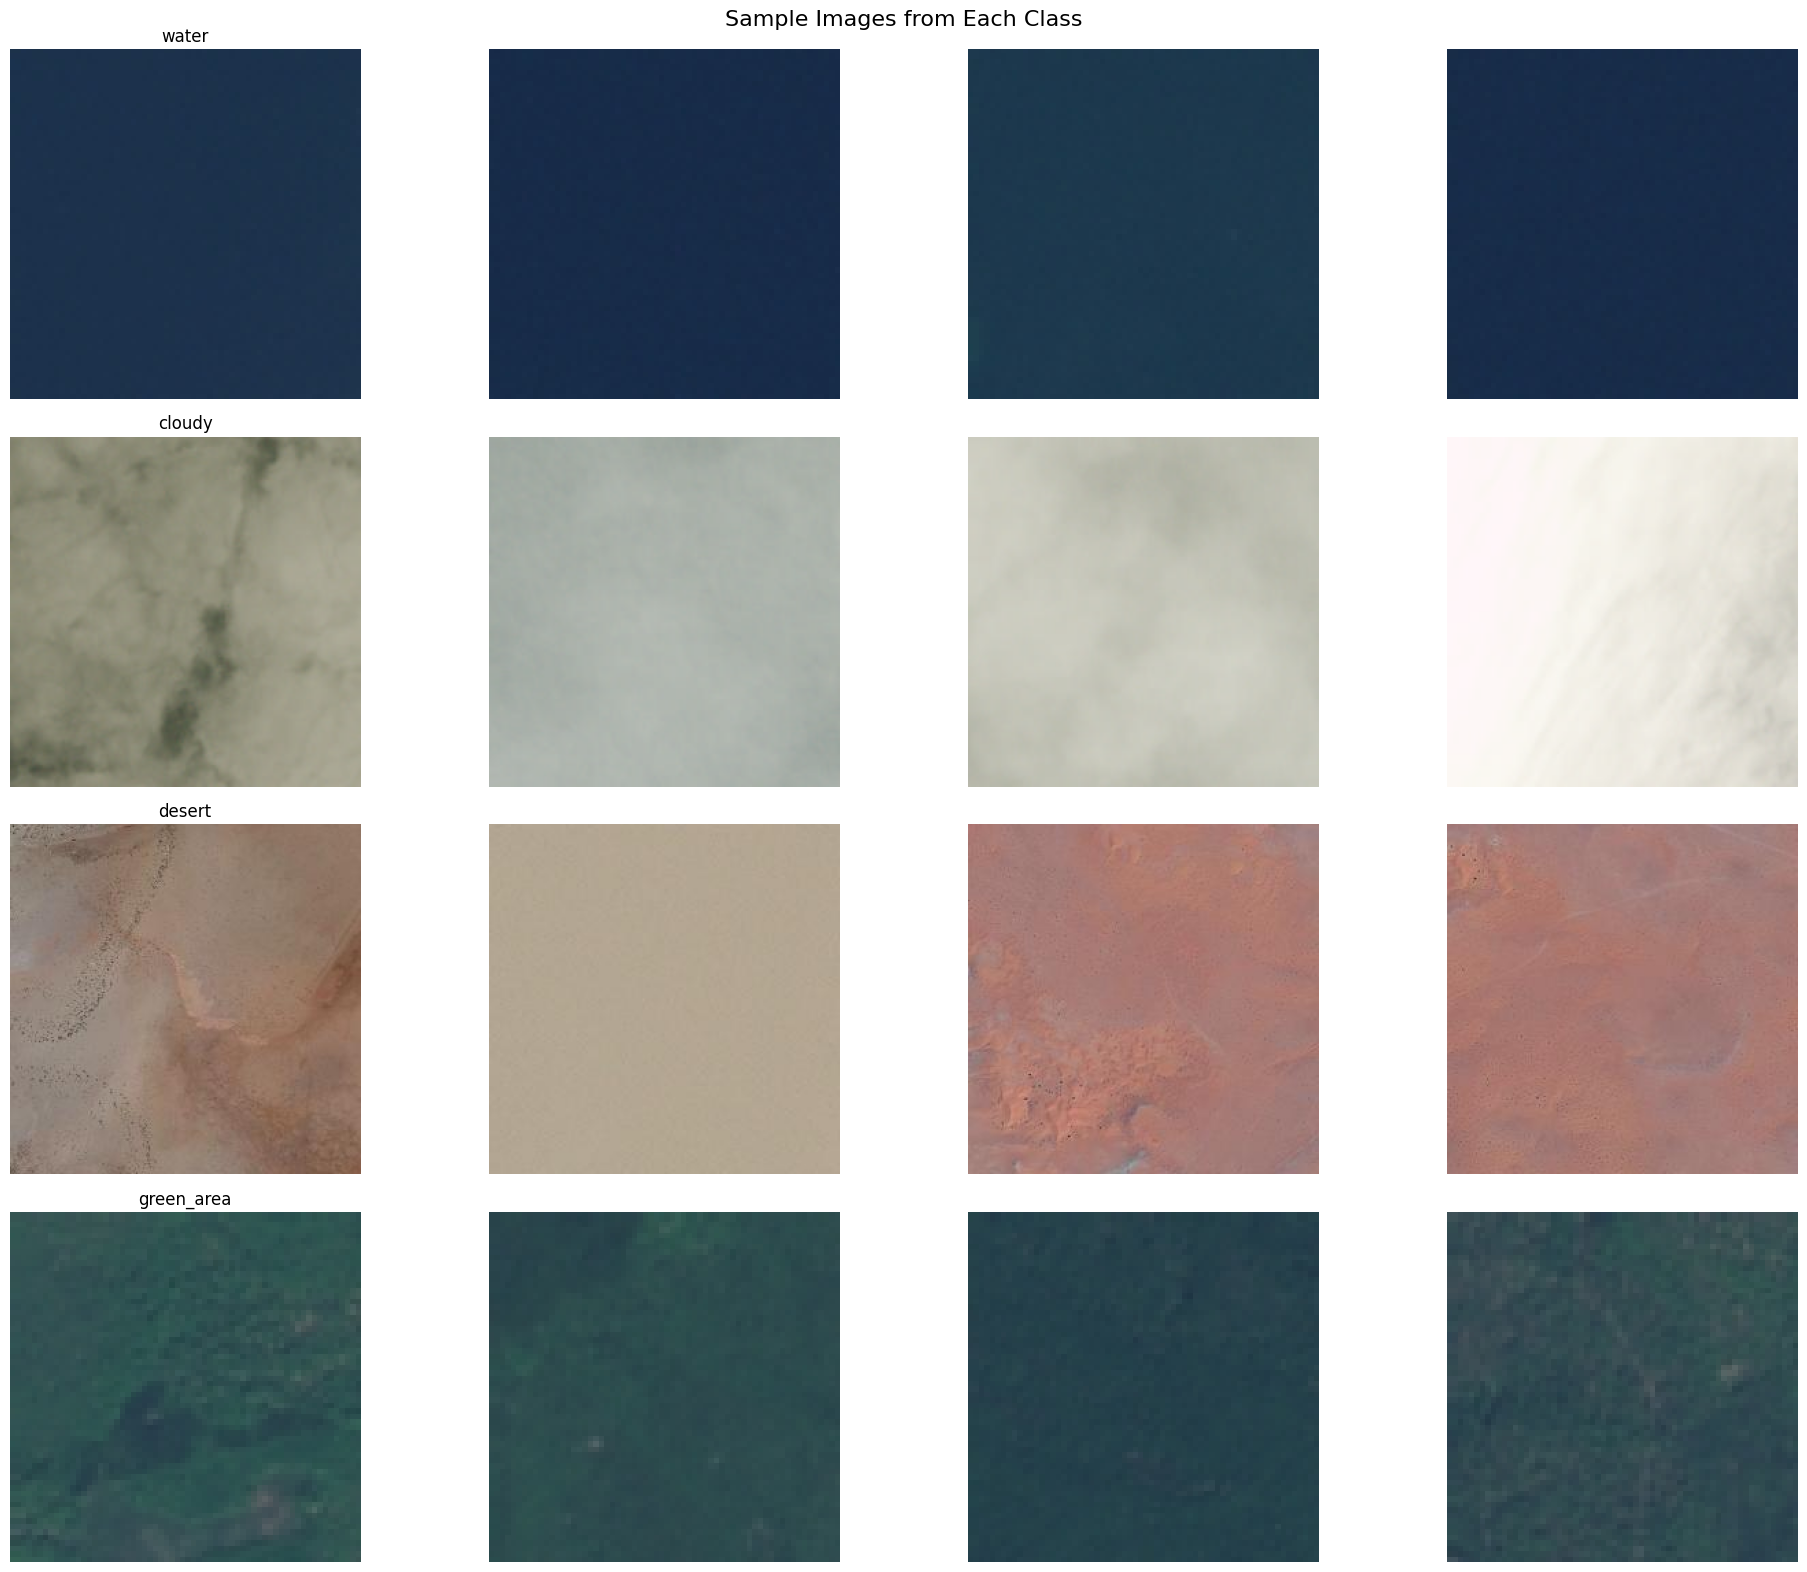

In [8]:
# Get unique classes
classes = df['label'].unique()

# Number of images to display per class
n_images = 4

# Set up the plot
fig, axes = plt.subplots(len(classes), n_images, figsize=(20, 4*len(classes)))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for i, class_name in enumerate(classes):
    # Filter dataframe for current class
    class_df = df[df['label'] == class_name]

    # Randomly sample n_images from this class
    sample_images = class_df['image_path'].sample(n_images).tolist()

    for j, img_path in enumerate(sample_images):
        # Open and display the image
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

        # Set the title for the first image in each row
        if j == 0:
            axes[i, j].set_title(f'{class_name}', fontsize=12)

plt.tight_layout()
plt.show()

### split the data into train and test

In [9]:
# Define the split ratio
test_ratio = 0.20 # 20% of data will go to test

# split the data
train_df, test_df = train_test_split(df, test_size=test_ratio, stratify=df['label'], random_state=42)

print(f"Original dataset shape: {df.shape}")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")


# Print class distribution
print("\nClass distribution:")
print("Original:")
print(df['label'].value_counts(normalize=True))
print("\nTrain:")
print(train_df['label'].value_counts(normalize=True))
print("\nTest:")
print(test_df['label'].value_counts(normalize=True))

Original dataset shape: (5631, 2)
Train dataset shape: (4504, 2)
Test dataset shape: (1127, 2)

Class distribution:
Original:
label
water         0.266383
cloudy        0.266383
green_area    0.266383
desert        0.200852
Name: proportion, dtype: float64

Train:
label
water         0.26643
green_area    0.26643
cloudy        0.26643
desert        0.20071
Name: proportion, dtype: float64

Test:
label
water         0.266193
green_area    0.266193
cloudy        0.266193
desert        0.201420
Name: proportion, dtype: float64


### define image transforms (Augmenter)

In [10]:
IMAGE_SIZE = 124

# this will be used during training, this will hold all the augmentation/transformation configs
training_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                             transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# this will be used during testing / infernece, wo don't want any kind of additional transformation applied at the time of running model prediction in test / production inviroment
test_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                             transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


### Custom Pytorch Dataset

In [12]:
# Define custom Dataset -> this will help you load images from your csv file
class CustomTrainingData(Dataset):
    def __init__(self, csv_df, class_list, transform=None):
        self.df = csv_df
        self.transform = transform
        self.class_list = class_list

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        image = Image.open(self.df.iloc[index].image_path).convert('RGB')
        label = self.class_list.index(self.df.iloc[index].label)

        if self.transform:
            image = self.transform(image)

        return image, label

# list of classes in your dataset
CLASS_LIST = ['water', 'cloudy', 'desert', 'green_area']

# create data object
train_data_object = CustomTrainingData(train_df, CLASS_LIST, training_transform)
test_data_object = CustomTrainingData(test_df, CLASS_LIST, test_transform)

### Dataloader

In [13]:
BATCH_SIZE = 32

# now define dataloader, this will load the images batches from CustomTrainingData object
train_loader = DataLoader(train_data_object, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data_object, batch_size=BATCH_SIZE, shuffle=True)

### define the model architecture

In [14]:
class SatelliteImageClassifier(nn.Module):
    def __init__(self, num_classes, input_size=(128, 128), channels=3):
        super(SatelliteImageClassifier, self).__init__()

        self.input_size = input_size
        self.channels = channels

        # Convolutional layers
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Calculate the size of the flattened features
        self._to_linear = None
        self._calculate_to_linear(input_size)

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _calculate_to_linear(self, input_size):
        # This function calculates the size of the flattened features
        x = torch.randn(1, self.channels, *input_size)
        self.conv_forward(x)

    def conv_forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.conv_forward(x)

        # Flatten the output for the fully connected layer
        x = x.view(-1, self._to_linear)

        # Fully connected layers with ReLU and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### define all the model config (learning rate, loss function, image size, batch size, epochs, etc)

In [18]:
# list of classes in your dataset
CLASS_LIST = ['water', 'cloudy', 'desert', 'green_area']

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 0.001
NUM_CLASSES = len(CLASS_LIST)
INPUT_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
CHANNELS = 3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### create SatelliteImageClassifier model object

In [19]:
# Initialize the model
model = SatelliteImageClassifier(NUM_CLASSES, INPUT_SIZE, CHANNELS).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
# Print model summary
print(model)

# If you want to see the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Test with a random input
test_input = torch.randn(1, CHANNELS, *INPUT_SIZE).to(device)
output = model(test_input)
print(f"Output shape: {output.shape}")

SatelliteImageClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)
Total number of parameters: 6814468
Output shape: to

### training loop

In [21]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Epoch [{epoch+1}/{EPOCHS}]')
    print(f'Accuracy on test set: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('-----------------------------')

print('Training finished!')

# Save the model
torch.save(model.state_dict(), 'satellite_classifier.pth')

Epoch [1/2], Loss: 0.7817
Epoch [1/2]
Accuracy on test set: 88.73%
Precision: 0.9010
Recall: 0.8873
F1 Score: 0.8858
-----------------------------
Epoch [2/2], Loss: 0.3681
Epoch [2/2]
Accuracy on test set: 89.35%
Precision: 0.9005
Recall: 0.8935
F1 Score: 0.8928
-----------------------------
Training finished!


In [22]:
def plot_image(image):
    """
    Plot an image using matplotlib.

    Parameters:
    image : PIL.Image or numpy.ndarray
        The image to be plotted. Can be a PIL Image object or a numpy array.
    """
    # Convert PIL Image to numpy array if necessary
    if isinstance(image, Image.Image):
        image = np.array(image)

    plt.imshow(image)

    plt.axis('off')  # Hide axes
    plt.show()

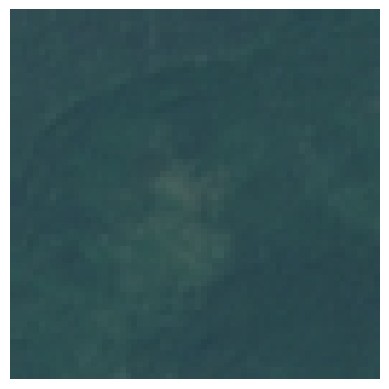

In [23]:
# Example usage
img = Image.open('data/green_area/Forest_846.jpg')
plot_image(img)

In [24]:
del model

### inference function (load saved model weight and run inference on actual images)

In [28]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_SIZE = (124, 124)
CHANNELS = 3

model = SatelliteImageClassifier(NUM_CLASSES, INPUT_SIZE, CHANNELS).to(device)
# Load the saved state dictionary
state_dict = torch.load('satellite_classifier.pth')
# Load the state dictionary into your model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.to(device).eval()


# this will be used during testing / infernece, wo don't want any kind of additional transformation applied at the time of running model prediction in test / production inviroment
test_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                             transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

CLASS_LIST = ['water', 'cloudy', 'desert', 'green_area'] # list of classes in your dataset


# Inference script
def predict(image_path):
    image_pil = Image.open(image_path).convert('RGB')
    image = test_transform(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        # Apply softmax to the output
        softmax_output = F.softmax(output, dim=1)

        print(f'Model raw output: {output}')
        print(f'Softmax output: {softmax_output}')

        # Get the predicted class and its confidence
        confidence, predicted = torch.max(softmax_output, 1)

        predicted_class = CLASS_LIST[predicted.item()]
        confidence = confidence.item()



    print(f'Predicted class: {predicted_class}')
    print(f'Confidence: {confidence:.4f}')
    plot_image(image_pil)


Model raw output: tensor([[ -7.5801,   6.5057,   1.6052, -11.7554]], device='cuda:0')
Softmax output: tensor([[7.5751e-07, 9.9261e-01, 7.3877e-03, 1.1644e-08]], device='cuda:0')
Predicted class: cloudy
Confidence: 0.9926


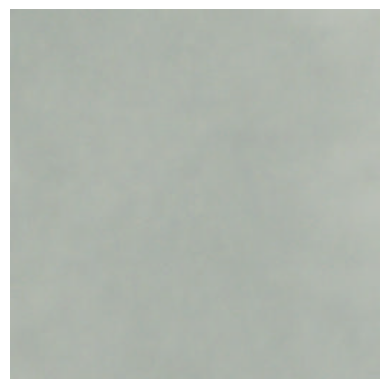

In [ ]:
predict("data/cloudy/train_24777.jpg")

Model raw output: tensor([[  4.0157,  -7.6036, -12.5321,   3.6128]], device='cuda:0')
Softmax output: tensor([[5.9936e-01, 5.3889e-06, 3.9004e-08, 4.0063e-01]], device='cuda:0')
Predicted class: water
Confidence: 0.5994


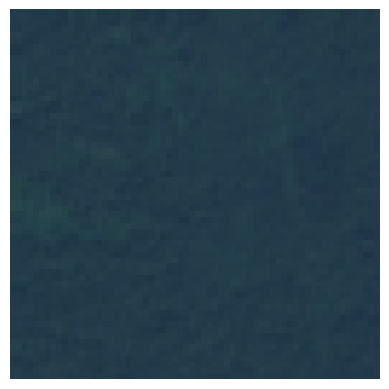

In [ ]:
predict("data/green_area/Forest_1731.jpg")

Lets run on this image from google images
https://www.fao.org/fileadmin/user_upload/gfoi/imgs/1_Remaining%20tropical%20rainforest%20patches.png

To download this image run
```
!wget https://www.fao.org/fileadmin/user_upload/gfoi/imgs/1_Remaining%20tropical%20rainforest%20patches.png
```

Model raw output: tensor([[ -1.5463,  -5.0433, -20.4949,  23.9693]], device='cuda:0')
Softmax output: tensor([[8.2927e-12, 2.5117e-13, 4.8916e-20, 1.0000e+00]], device='cuda:0')
Predicted class: green_area
Confidence: 1.0000


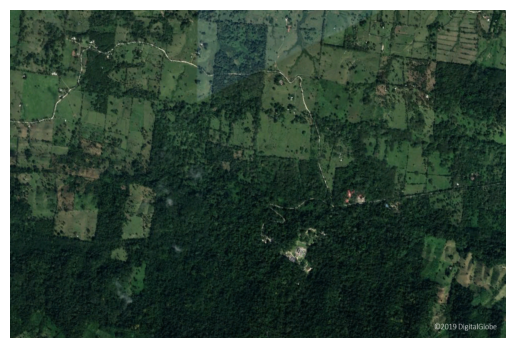

In [ ]:
predict("1_Remaining tropical rainforest patches.png")